# A quick-start to calculating catchmentwide erosion rates
Copy this jupyter notebook together with the folder `test_data` to any location on your computer.<br>
Note that a folder `plots` will be created in your working directory for graphical output.

In [1]:
# Install the riversand package if you haven't done so:
#% pip install riversand

## Setup

In [2]:
import pandas as pd
import numpy as np

import riversand

# Create a new 'Riversand' object and specify the folder with the input data:
rv = riversand.Riversand("test_data")

Specify the location of the **input data folder**: `"test_data"` is a subfolder in the working directory. Other possibilities include `"./test_data"` (relative path to the input data) or `"/path/to/data"` or `"C:\\path\to\data"` (absolute path; depending on your operating system).

Use `rv = riversand.Riversand()` if the data are stored in the working directory or to explicitely specify the path with every data set that is added to the project.

## Example 1: Single catchment
### Raster data
You can add three types of raster datasets (geotiffs): `'elevation'`, `'shielding'` and `'quartz'`. All raster data must have the same projection and resolution. Projection must be equal area (e.g. UTM), geographic coordinate reference systems (lat/long) are not permitted.

- 'elevation' is in meters above sea level
- 'shielding' is a factor between 0 and 1
- 'quartz' is a binary raster with 1 indicating quartz-bearing and 0 indicating quartz-free lithologies

An elevation raster is mandatory. 

In [3]:
# Add raster data:
rv.add_raster('dem_utm_35m.tif', dtype='elevation')
rv.add_raster('toposhielding_35m.tif', dtype='shielding') # optional 
#rv.add_raster('quartz_35m.tif', dtype='quartz') # optional

There are some **plotting** functions to quickly explore the uploaded raster data:

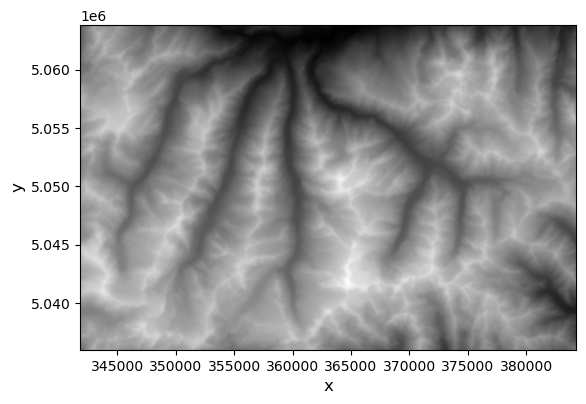

In [4]:
riversand.plot_raster(rv) # by default, the elevation raster is displayed
#riversand.plot_raster(rv, dtype='shielding') # specify, which raster to display

### Sample data
Sample and nuclide information can be added manually or imported from a spreadsheet. The requirements are those for the online calculator (see  http://stoneage.hzdr.de/docs/documentation.html#input_format).<br>

A more detailed description of sample data is given at the end of this notebook.

In [5]:
# Add sample data manually:
test = {'name'   : 'Ph-1',   # sample name
        'N'      : 1.2e6,    # nuclide concentration, at/g
        'delN'   : 3.6e4,    # uncertainty, at/g
        'nuclide': 'Be-10',  # nuclide 'Be-10' or 'Al-26'
        'density': 2.1,      # density, g/cm3
      }
rv.add_samples(test) # add the sample to the project
rv.samples # display dataset; note that default values are filled in, e.g. for the year of sampling

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Ph-1,std,0,2.1,1.0,0,2010,Be-10,quartz,1200000,36000,07KNSTD


### Catchment shapefile
The catchment shapefile must have the same projection as the raster data. Use the function `.validate()` to confirm that all geospatial data have the same projection. Use `rv` to show all data that are uploaded.

In [6]:
# Add catchment shapefile with a single catchment polygon:
rv.add_catchments('test_single_catchment.shp')

In [7]:
# Validate the dataset:
rv.validate()


Raster data valid
Sample data valid
Catchment data valid


In [8]:
# Display a summary of the dataset:
rv

---------------
Raster data:

dtype : elevation
fname : test_data/dem_utm_35m.tif
src   : <closed DatasetReader name='test_data/dem_utm_35m.tif' mode='r'>
epsg  : 32632
res   : (35.0, 35.0)

dtype : shielding
fname : test_data/toposhielding_35m.tif
src   : <closed DatasetReader name='test_data/toposhielding_35m.tif' mode='r'>
epsg  : 32632
res   : (35.0, 35.0)

---------------
Sample data:
1 sample(s)

---------------
Catchment polygons:

fname : test_data/test_single_catchment.shp
src   : <closed Collection 'test_data/test_single_catchment.shp:test_single_catchment', mode 'r' at 0x7f8b53989ea0>
attrs : ['name', 'id']
len   : 1
epsg  : 32632

---------------
Validated projection:
epsg  : 32632
res   : (35.0, 35.0)

### Processing

Continue only if the dataset is validated (function `.validate()`).

The following parameters need to be specified:
 - `bins` : bin size for elevation statistics in metres.
 - `scaling` : scaling method as implemented in the online calculator: `'St'`, `'Lm'` or `'LSDn'.`
 - `shielding` : method for shielding correction:<br>
     - `'topo'` : compute from shielding raster; raises an error if no shielding raster is defined.<br>
     - `'sample'` : use value from sample dataset; raises an error if no shielding is defined for the sample.<br>
     - `numeric` : use a constant value between 0 and 1.
     
Optional parameters:
 - `plot` : `'jpg'` or `'png'` to save plots with an automatically generated name or `'show'` to display the plots.
 - `unit` : unit of erosion rates for display; `riversand.params.units` shows all valid options.

Plots are saved in a folder `plots` in the current working directory. Existing files with identical names will be overwritten.

In [9]:
# Process a single catchment:
results1 = rv.process_single_catchment(bins=100,
                                       scaling='LSDn',
                                       shielding='topo',
                                       plot='jpg',
                                       unit='mm/kyr')

Processing single catchment
Bin size : 100 m
Scaling method : LSDn
Topographic shielding from topo data
Saving plots as .jpg in './plots'



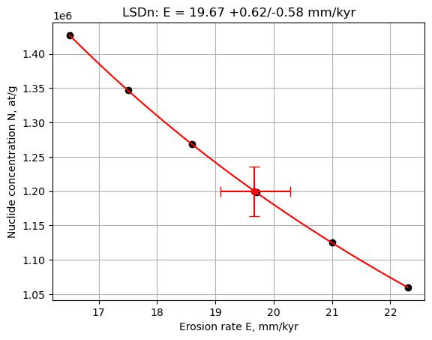

If the parameter `plot` is set a **figure** is saved as `./plots/0_Ph-1_LSDn.jpg`:
- The black points are six initial erosion rates $E$ sent to the online calculator and the nuclide concentrations $N(E)$ predicted by the online calculator.
- The red curve is a polynomial fit $N(E)$.
- The red point and vertical error bar are the input nuclide concentration and uncertainty of the sample $N \pm delN$.
- The horizontal error bar is the uncertainty on the erosion rate resulting from the analytical uncertainty $delN$; it depends on the shape of the function $N(E)$ and is therefore asymmetric.

Note that the units for this plot are defined by the parameter `unit`.

**Results table**: Erosion rate `E` and uncertainty `delE` are in cm/yr. `NRMSE` is the normalised root mean squared error.

Use `.to_excel()` to save the results to Excel or OpenOffice or `.to_csv()` for comma-separated values. This may require additional packages such as `openpyxl` or `odfpy`.

In [10]:
results1 # display results (cm/yr)

,name,scaling,nuclide,E,delE-,delE+,NRMSE,error
0,Ph-1,LSDn,Be-10 quartz,0.001967,0.000058,0.000062,0.000012,


In [11]:
results1.to_excel('Example1_LSDn.xlsx') # Excel

## Example 2: Same catchment, different settings
Repeat the analysis with a **correction for quartz-free lithologies** and with a **constant shielding factor** of 0.95. 

In [12]:
# Add a quartz raster dataset:
rv.add_raster('quartz_35m.tif', dtype='quartz')

In [13]:
# Process with a constant shielding factor 'shielding=0.95':
results2 = rv.process_single_catchment(bins=100,
                                       scaling='LSDn',
                                       shielding=0.95)
results2 # display results (cm/yr)

Processing single catchment
Bin size : 100 m
Scaling method : LSDn
Topographic shielding : 0.95
Correcting for quartz-free lithologies

Removed 61.9 % of the catchment as quartz-free


,name,scaling,nuclide,E,delE-,delE+,NRMSE,error
0,Ph-1,LSDn,Be-10 quartz,0.00167,0.000049,0.000052,0.000114,


In [14]:
results2.to_excel('Example2_LSDn_Qtz.xlsx') # save data to spreadsheet

## Example 3: Multi-catchment dataset

To process a shapefile with more than one catchment polygon import sample data from a spreasdsheet. The spreadsheet must have a column `name` with sample names that are used to match samples to catchment polygons. You also need to specify, which attribute field of the shapefile to use for catchment names ("catchment identifier" `cid`).

In [15]:
# Create a new Riversand object:
rv = riversand.Riversand("test_data")

# Add raster datasets:
rv.add_raster('dem_utm_35m.tif', dtype='elevation') 
rv.add_raster('toposhielding_35m.tif', dtype='shielding') # optional
rv.add_raster('quartz_35m.tif', dtype='quartz') # optional

# Add sample data from a spreadsheet:
rv.add_samples('test_samples.ods') # .xlsx, .ods, .csv
rv.samples # display dataset; columns lat, long and elev are irrelevant and will be ignored

,name,density,shielding,nuclide,N,delN,lat,long,elev
0,DB01,2.7,0.92,Be-10,12900,700,45.8040,6.9653,1230
1,DB02,2.7,0.94,Be-10,10800,700,45.7167,7.1101,783
2,DB03,2.7,0.94,Be-10,23500,1400,45.6925,7.1935,699
3,DB04,2.7,0.94,Be-10,22000,1100,45.7003,7.2019,664
4,DB05,2.7,0.95,Be-10,20500,1000,45.7001,7.2337,638
5,DB06,2.7,0.95,Be-10,15400,800,45.5228,7.8375,251
6,DB07,2.7,0.95,Be-10,22500,2600,45.5962,7.7956,325
7,DB08,2.7,0.96,Be-10,48500,2100,45.6118,7.7310,373
8,DB12,2.7,0.95,Be-10,12600,800,45.7183,7.2651,594
9,DB17,2.7,0.95,Be-10,27100,1300,45.7039,7.1622,689


In [16]:
# Add catchment shapefile with one or several catchment polygons:
rv.add_catchments('test_multi_catchment.shp')

rv.catchments # display some info on the catchment data

fname : test_data/test_multi_catchment.shp
src   : <closed Collection 'test_data/test_multi_catchment.shp:test_multi_catchment', mode 'r' at 0x7f8b4942eb90>
attrs : ['name', 'id', 'area_km2']
len   : 8
epsg  : 32632

This shapefile has three attribute fields (`attrs`): 'name', 'id' and 'area_km2'. In this example, the field 'name' has the catchment names:

In [17]:
# Set the catchment identifier:
rv.set_cid('name')

In [18]:
# Get all valid catchments:
rv.get_valid_catchments()

['DB02', 'DB03', 'DB04', 'DB05', 'DB17']

There are 10 entries in the sample spreadsheet (`rv.samples`) and 8 polygons in the shapefile (`rv.catchments`) but only 5 matching datasets were found (function `.get_valid_catchments()`).

Get the complete list of catchment names from the shapefile with `.catchments.get_names()`. In this example, there is no sample data for one of the catchments (DB19) and no catchment polygon for three of the samples (DB06, DB07, DB08). Catchments that have non-unique names (DB12) are also excluded.

In [19]:
# Get all catchment names from the shapefile:
rv.catchments.get_names()

['DB02', 'DB03', 'DB04', 'DB05', 'DB12', 'DB12', 'DB17', 'DB19']

In [20]:
# Validate the dataset:
rv.validate()


Raster data valid
Sample data valid
Catchment data valid

Valid catchments / samples:
   Found 5 match(es)


In [21]:
# Process a multi-catchment dataset:
results = rv.process_multi_catchment(bins=100,
                                     scaling='LSDn',
                                     shielding='topo',
                                     unit='mm/kyr',
                                     plot='jpg')

Processing multi-catchment dataset
Bin size : 100 m
Scaling method : LSDn
Topographic shielding from topo data
Correcting for quartz-free lithologies
Saving plots as .jpg in './plots'


 0 DB01 : no catchment polygon
 1 DB02 : catchment out of bounds
 2 DB03 : 789.6+/-51.1 mm/kyr
 3 DB04 : 829.8+/-44.7 mm/kyr
 4 DB05 : 763.9+/-39.9 mm/kyr
 5 DB06 : no catchment polygon
 6 DB07 : no catchment polygon
 7 DB08 : no catchment polygon
 8 DB12 : no catchment polygon
 9 DB17 : 679.3+/-34.6 mm/kyr


In [22]:
results # display results (cm/yr)

,name,scaling,nuclide,qtz,E,delE-,delE+,NRMSE,error
0,DB01,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
1,DB02,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,catchment out of bounds
2,DB03,LSDn,Be-10 quartz,55.428851,0.07896,0.004502,0.005113,0.000159,
3,DB04,LSDn,Be-10 quartz,68.534972,0.082983,0.004026,0.004468,0.000224,
4,DB05,LSDn,Be-10 quartz,38.067225,0.076386,0.003608,0.003987,0.000363,
5,DB06,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
6,DB07,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
7,DB08,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
8,DB12,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
9,DB17,LSDn,Be-10 quartz,91.615061,0.06793,0.003154,0.00346,0.000014,


In addition to the invalid catchments/samples determined above, catchment DB02 is out of bounds of the raster datasets, and no erosion rate can be calculated.

**Results table**:

- `E`, `delE+` and `delE-` are the catchmentwide erosion rate and (asymmetric) uncertainty in cm/yr.
- `NRMSE` is the normalized root mean squared error; a warning is issued for samples with NRMSE>1e-3 indicating a poor fit of the polynomial function.
- If a quartz raster is available, the column `qtz` shows the quartz-bearing area of the catchment in percent.
- `error` indicates errors that may have occurred during the calculation.


The table has the same ordering of the samples as the input table `rv.samples` for easy merging of the spreadsheets.

Drop empty rows with `results = results[results['E'].notna()]` if desired.

In [23]:
results.to_excel('Example3_LSDn.xlsx') # save data to spreadsheet

In [24]:
# same table without the empty rows
results = results[results['E'].notna()]
results.to_excel('Example3_LSDn_short.xlsx') # save short version to spreadsheet
results

,name,scaling,nuclide,qtz,E,delE-,delE+,NRMSE,error
2,DB03,LSDn,Be-10 quartz,55.428851,0.07896,0.004502,0.005113,0.000159,
3,DB04,LSDn,Be-10 quartz,68.534972,0.082983,0.004026,0.004468,0.000224,
4,DB05,LSDn,Be-10 quartz,38.067225,0.076386,0.003608,0.003987,0.000363,
9,DB17,LSDn,Be-10 quartz,91.615061,0.06793,0.003154,0.00346,0.000014,


## Sample data
(see also http://stoneage.hzdr.de/docs/documentation.html#input_format)

Columns that are recognized (processed) by the calculator are `name`, `press_flag`, `thickness`, `density`, `shielding`, `erate`, `year`, `nuclide`, `mineral`, `N`, `delN` and `standardization`; any additional columns are ignored.

Mandatory columns are:
- `name` : Sample name consisting of letters, numbers and hyphens; avoid names that may be misinterpreted as numbers: use 'A2' instead of '2'.
- `N` and `delN` : Nuclide concentration and uncertainty in atoms/grams quartz.

Optional columns are:
- `press_flag` : Atmospheric pressure model, 'std' or 'ant'; the default is 'std'.
- `density` : Subtrate density in g/cm3; the default is 2.65.
- `year` : Year of sampling; the default is 2010.
- `nuclide` : 'Be-10' or 'Al-26'; the default is 'Be-10'.
- `shielding` : A catchmentwide shielding factor; these values are ignored if shielding is calculated from a raster dataset, the default is 1.

Default values (see `riversand.params.default_values`) are used if a column is missing. Columns `thickness`, `erate` and `mineral` (only valid value: 'quartz') are irrelevant for the calculation of catchmentwide erosion rates, but if they are present they must contain valid values. All additional columns are ignored.

The `name` is used to match samples to catchment polygons. If several samples were measured from the same location, or if both Al-26 and Be-10 were measured, the data must be in separate rows with the same sample name.

The calculator assumes standardizations of '07KNSTD' for Be-10 and 'KNSTD' for Al-26 data. If your samples have been measured against a different standard you can use the following correction factors to re-standardize your data:<br>
http://hess.ess.washington.edu/math/docs/al_be_v22/AlBe_standardization_table.pdf<br>
(see also http://stoneage.hzdr.de/docs/documentation.html#standardization)

## Version of the online calculator

In [25]:
# Get the version of the online calculator used for the calculation
riversand.get_version() 

{'wrapper': '3.0',
 'validate': 'validate_v3_input.m - 3.0',
 'erates': '3.0',
 'muons': '3.1',
 'consts': '2022-12-03'}